In [12]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.model_selection import train_test_split
import pykalman

In [13]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT' ]

df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2018-12-24,205.160004,94.129997
2018-12-26,222.949997,100.559998
2018-12-27,225.139999,101.180000
2018-12-28,223.130005,100.389999
2018-12-31,226.240005,101.570000


In [14]:
def KalmanFilterRegression(x,y):
    from pykalman import KalmanFilter

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, state_covs = kf.filter(y.values)
    return state_means

In [15]:
def backtest(df, state_means, spread, transaction_cost=0.0005):
    spread_mean = spread.rolling(window=30).mean()
    spread_std = spread.rolling(window=30).std()
    zscore = (spread - spread_mean) / spread_std

    signals = pd.Series(0, index=df.index)
    signals[zscore < -2] = 1  
    signals[zscore > 2] = -1  
    signals[(zscore > -0) & (signals == 1)] = 0  
    signals[(zscore < 0) & (signals == -1)] = 0  
    signals = signals.ffill().fillna(0)

    hedge_ratio = state_means[:, 1]
    spread_pct_change = spread.diff() / (df['ADBE'] * abs(hedge_ratio) + df['MSFT'])
    strategy_returns = spread_pct_change * signals.shift(1)

    position_changes = signals.diff().fillna(0)
    strategy_returns -= abs(position_changes) * transaction_cost

    cumulative_pnl = (1 + strategy_returns).cumprod()

    return cumulative_pnl


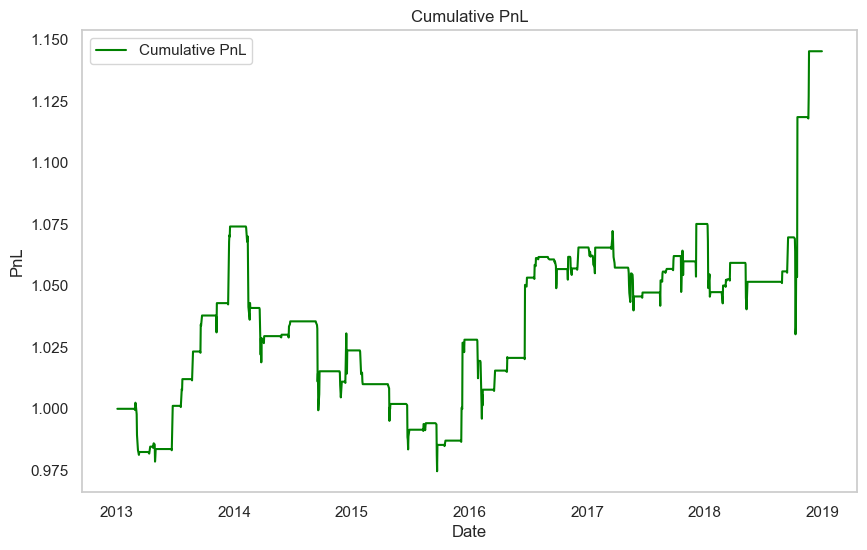

In [16]:
state_means = KalmanFilterRegression(df['ADBE'], df['MSFT'])
spread = df['MSFT'] - (state_means[:, 0] + state_means[:, 1] * df['ADBE'])

cumulative_pnl = backtest(df, state_means, spread)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL', color='green')
plt.title('Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()
